In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import ast
import re
import urllib
import scipy.stats as stats

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

%matplotlib inline
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

In [2]:
calendar = pd.read_csv('data/calendar.csv.gz')
reviews = pd.read_csv('data/reviews.csv.gz')
listings = pd.read_csv('data/listings.csv.gz')

In [3]:
calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27935194 entries, 0 to 27935193
Data columns (total 7 columns):
 #   Column          Dtype  
---  ------          -----  
 0   listing_id      int64  
 1   date            object 
 2   available       object 
 3   price           object 
 4   adjusted_price  object 
 5   minimum_nights  float64
 6   maximum_nights  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 1.5+ GB


In [4]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76534 entries, 0 to 76533
Data columns (total 74 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            76534 non-null  int64  
 1   listing_url                                   76534 non-null  object 
 2   scrape_id                                     76534 non-null  int64  
 3   last_scraped                                  76534 non-null  object 
 4   name                                          76510 non-null  object 
 5   description                                   73372 non-null  object 
 6   neighborhood_overview                         46750 non-null  object 
 7   picture_url                                   76534 non-null  object 
 8   host_id                                       76534 non-null  int64  
 9   host_url                                      76534 non-null 

In [5]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1163886 entries, 0 to 1163885
Data columns (total 6 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   listing_id     1163886 non-null  int64 
 1   id             1163886 non-null  int64 
 2   date           1163886 non-null  object
 3   reviewer_id    1163886 non-null  int64 
 4   reviewer_name  1163885 non-null  object
 5   comments       1163374 non-null  object
dtypes: int64(3), object(3)
memory usage: 53.3+ MB


In [6]:
reviews_places = pd.merge(reviews, listings[['id', 'price', 'latitude', 'longitude', 'neighbourhood_cleansed']], left_on='listing_id', right_on='id')

In [7]:
reviews_places.date = pd.to_datetime(reviews_places.date)
reviews_places.price = reviews_places.price.str.replace(r'[,|$]', '').astype('float')

>The frequency of reviews is a good indicator of Airbnb activities, the plunge of such activities in 2020 by around 80% could be directly attributed to Covid-19.

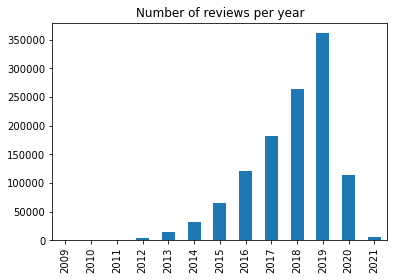

In [8]:
reviews_places.date.dt.year.sort_values().value_counts(sort=False).plot(kind='bar')
plt.title('Number of reviews per year');

In [9]:
reviews_frequency_2019 = len(reviews_places[reviews_places.date == '2019'])
reviews_frequency_2020 = len(reviews_places[reviews_places.date == '2020'])
(reviews_frequency_2020 - reviews_frequency_2019) / reviews_frequency_2019

0.19710144927536233

In [10]:
reviews_2019 = reviews_places[reviews_places.date == '2019']
reviews_2019_unique = reviews_2019.loc[~reviews_2019.listing_id.duplicated()]
reviews_2020 = reviews_places[reviews_places.date == '2020']
reviews_2020_unique = reviews_2020.loc[~reviews_places.listing_id.duplicated()]

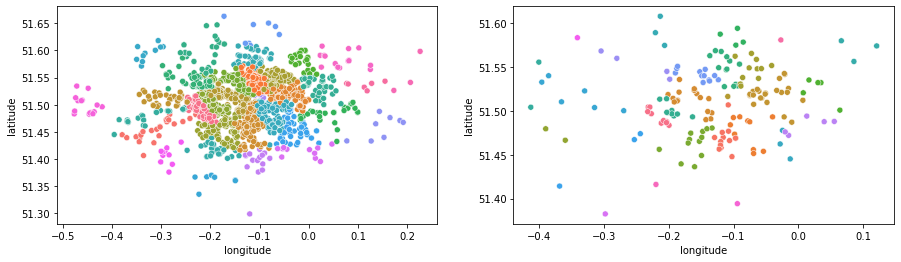

In [97]:
fig = plt.figure(figsize=(15, 4))
ax1 = fig.add_subplot(121)
sns.scatterplot(ax=ax1, x='longitude', y='latitude', data=reviews_2019_unique, hue='neighbourhood_cleansed')
ax2 = fig.add_subplot(122)
sns.scatterplot(ax=ax2, x='longitude', y='latitude', data=reviews_2020_unique, hue='neighbourhood_cleansed')
ax1.legend_.remove()
ax2.legend_.remove()

---

### Analysis on demographics of reviewers by language

>Here a one-tailed test is performed on people who left a review that includes atleast one Chinese character. This test is conducted on the more expensive listings where price exceeds $100.

In [12]:
reviews_places['comments_chinese'] = reviews_places.comments.map(lambda x: bool(re.search(u'[\u4e00-\u9fff]', str(x))))

In [13]:
chinese = reviews_places[(reviews_places.price > 100) & reviews_places.comments_chinese].price.describe()
chinese

count     3122.000000
mean       199.648302
std        417.849254
min        101.000000
25%        124.000000
50%        150.000000
75%        205.000000
max      15971.000000
Name: price, dtype: float64

In [14]:
non_chinese = reviews_places[(reviews_places.price >100) & ~reviews_places.comments_chinese].price.describe()
non_chinese

count    275571.000000
mean        213.251275
std         722.707733
min         101.000000
25%         120.000000
50%         147.000000
75%         199.000000
max       17746.000000
Name: price, dtype: float64

>Null hypothesis: a person who left a review with at least one Chinese character wouldn't on average spend less
Alternative hypothesis: a person who left a review with at least one Chinese character spends less on average

In [15]:
deviation_95 = stats.norm.ppf(0.95) * np.sqrt(chinese['std']**2 / chinese['count'] + non_chinese['std']**2 / non_chinese['count'])
deviation_95

12.507422895076553

In [16]:
chinese['mean'] + deviation_95 < non_chinese['mean']

True

>Hence the null hypothesis is rejected with 95% confidence

In [17]:
reviews_places['comment_english'] = reviews_places.comments.map(lambda x: str(x).isascii())

>A similar hypothesis test is performed on reviews which are not exclusively written with English (ASCII) characters

In [18]:
non_english = reviews_places[~reviews_places.comment_english].price.describe()
non_english

count    244313.000000
mean         94.577133
std         410.175137
min           8.000000
25%          40.000000
50%          64.000000
75%         100.000000
max       17746.000000
Name: price, dtype: float64

In [19]:
english = reviews_places[reviews_places.comment_english].price.describe()
english

count    919573.000000
mean         91.372755
std         344.625716
min           8.000000
25%          39.000000
50%          61.000000
75%         100.000000
max       17746.000000
Name: price, dtype: float64

>Null hypothesis: people who leave a review that includes a non-English character have mean spending equal to others
>Alternative hypothesis: people who leave a review with non-English character(s) have different spending mean compared to others

In [20]:
deviation_95 = stats.norm.ppf(0.975) * np.sqrt(english['std']**2 / english['count'] + non_english['std']**2 / non_english['count'])
deviation_95

1.7724340551496316

In [21]:
(english['mean'] + deviation_95) < non_english['mean']

True

>Hence the null hypothesis has been rejected with 95% confidence

---

### Analysis on comments length with price

>Here ANOVA is conducted if the relationship between the price bracket of spending and length of reviews.

In [22]:
reviews_places['bracket'] = pd.qcut(reviews_places.price, 4)
reviews_places['comments_length'] = reviews_places.comments.str.len()

In [23]:
reviews_places.groupby('bracket').comments_length.mean()

bracket
(7.999, 40.0]       225.756599
(40.0, 62.0]        253.568784
(62.0, 100.0]       269.946506
(100.0, 17746.0]    285.324138
Name: comments_length, dtype: float64

>Here a hypothesis test is performed against a null hypothesis which states that the mean of length of comments doesn't depend on a person's spending price bracket.

In [24]:
reviews_places['bracket_mean'] = reviews_places.groupby('bracket').comments_length.transform('mean')
reviews_places['ssw_row'] = (reviews_places.comments_length - reviews_places.bracket_mean)**2
reviews_places.head()

,listing_id,id_x,date,reviewer_id,reviewer_name,comments,id_y,price,latitude,longitude,neighbourhood_cleansed,comments_chinese,comment_english,bracket,comments_length,bracket_mean,ssw_row
0,13913,80770,2010-08-18,177109,Michael,My girlfriend and I hadn't known Alina before ...,13913,40.0,51.56802,-0.11121,Islington,False,True,"(7.999, 40.0]",873.0,225.756599,418924.019916
1,13913,367568,2011-07-11,19835707,Mathias,Alina was a really good host. The flat is clea...,13913,40.0,51.56802,-0.11121,Islington,False,True,"(7.999, 40.0]",172.0,225.756599,2889.771954
2,13913,529579,2011-09-13,1110304,Kristin,Alina is an amazing host. She made me feel rig...,13913,40.0,51.56802,-0.11121,Islington,False,True,"(7.999, 40.0]",350.0,225.756599,15436.422649
3,13913,595481,2011-10-03,1216358,Camilla,"Alina's place is so nice, the room is big and ...",13913,40.0,51.56802,-0.11121,Islington,False,True,"(7.999, 40.0]",409.0,225.756599,33578.143947
4,13913,612947,2011-10-09,490840,Jorik,"Nice location in Islington area, good for shor...",13913,40.0,51.56802,-0.11121,Islington,False,True,"(7.999, 40.0]",98.0,225.756599,16321.748632


In [25]:
grand_mean = reviews_places.groupby('bracket').comments_length.mean().mean()
ssb = np.sum((reviews_places.groupby('bracket').comments_length.mean().values - grand_mean)**2 * reviews_places.groupby('bracket').size().values)
ssw = reviews_places.ssw_row.sum()

In [26]:
f_statistic = (ssb / (4 - 1)) / (ssw / (len(reviews_places) - 4))
f_statistic

3104.008683699421

In [27]:
stats.f.ppf(0.99, dfn=3, dfd=len(reviews_places)-4)

3.7816390496993186

>Since the calculated f-statistic is much greater than the critical f-value, the length of comments is dependent on spending price bracket with 99% confidence.

>In the calendar Dataframe convert the date column to datetime object and 
prices into float

In [28]:
calendar.date = pd.to_datetime(calendar.date)
calendar.price = calendar.price.str.replace(r'[,|$]', '').astype('float')
calendar.adjusted_price = calendar.adjusted_price.str.replace(r'[,|$]', '').astype('float')

In [29]:
calendar.describe()

,listing_id,price,adjusted_price,minimum_nights,maximum_nights
count,2.793519e+07,2.793468e+07,2.793468e+07,2.793276e+07,2.793276e+07
mean,2.608478e+07,1.264199e+02,1.261539e+02,6.142188e+00,8.679454e+05
std,1.353189e+07,3.524370e+02,3.517111e+02,2.741382e+01,4.283477e+07
min,1.391300e+04,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00
25%,1.526315e+07,4.500000e+01,4.400000e+01,1.000000e+00,9.000000e+01
50%,2.624739e+07,7.900000e+01,7.900000e+01,2.000000e+00,1.125000e+03
75%,3.833855e+07,1.340000e+02,1.330000e+02,4.000000e+00,1.125000e+03
max,4.810299e+07,1.774600e+04,1.774600e+04,1.125000e+03,2.147484e+09


>difference between price and adjusted price columns are zero for
95% of values

In [30]:
(calendar.price - calendar.adjusted_price).describe()

count    2.793468e+07
mean     2.659666e-01
std      7.071372e+00
min     -9.750000e+02
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.775000e+03
dtype: float64

In [31]:
(calendar.price - calendar.adjusted_price).quantile([0.025, 0.975])

0.025    0.0
0.975    0.0
dtype: float64

>check for duplicates and null values in calendar and then fill null values

In [32]:
calendar.duplicated().sum()

0

In [33]:
calendar.isnull().sum()

listing_id           0
date                 0
available            0
price              513
adjusted_price     513
minimum_nights    2432
maximum_nights    2432
dtype: int64

In [34]:
calendar_null_price_listings = calendar[calendar.price.isnull()].listing_id.unique()
calendar_null_price_listings

array([ 3323834, 21484800, 42100579])

In [35]:
calendar_null_price = calendar[calendar.price.isnull() & calendar.listing_id.isin(calendar_null_price_listings)]
calendar_null_price.groupby('listing_id').size()

listing_id
3323834     171
21484800    171
42100579    171
dtype: int64

In [36]:
calendar_notnull_price = calendar[calendar.price.notnull() & calendar.listing_id.isin(calendar_null_price_listings)]
calendar_notnull_price.groupby('listing_id').size()

listing_id
3323834     194
21484800    194
42100579    194
dtype: int64

In [37]:
calendar_notnull_price.groupby('listing_id').adjusted_price.mean()

listing_id
3323834     50.000000
21484800    52.835052
42100579    70.103093
Name: adjusted_price, dtype: float64

In [38]:
calendar_notnull_price.groupby('listing_id').adjusted_price.std()

listing_id
3323834     0.000000
21484800    4.518655
42100579    0.304867
Name: adjusted_price, dtype: float64

In [39]:
calendar = calendar.groupby('listing_id').apply(lambda g: g.fillna(g.mean()))
calendar.isnull().sum()

listing_id        0
date              0
available         0
price             0
adjusted_price    0
minimum_nights    0
maximum_nights    0
dtype: int64

>merge calendar and listings dataframes to obtain location features

In [40]:
calendar_places = pd.merge(calendar, listings[['id', 'latitude', 'longitude', 'neighbourhood_cleansed']], left_on='listing_id', right_on='id')

In [41]:
calendar_places.head()

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights,id,latitude,longitude,neighbourhood_cleansed
0,100326,2021-02-13,f,33.0,33.0,2.0,10.0,100326,51.56485,-0.05612,Hackney
1,100326,2021-02-14,f,33.0,33.0,2.0,10.0,100326,51.56485,-0.05612,Hackney
2,100326,2021-02-15,f,33.0,33.0,2.0,10.0,100326,51.56485,-0.05612,Hackney
3,100326,2021-02-16,f,33.0,33.0,2.0,10.0,100326,51.56485,-0.05612,Hackney
4,100326,2021-02-17,f,33.0,33.0,2.0,10.0,100326,51.56485,-0.05612,Hackney


>perform analysis on one year span from 9-2-2021 to 8-2-2020

In [42]:
calendar_date_min = calendar_places.date.min()
calendar_date_max = calendar_places.date.max()
calendar_date_max, calendar_date_min

(Timestamp('2022-02-20 00:00:00'), Timestamp('2021-02-09 00:00:00'))

In [43]:
calendar_one_year = calendar_places[(calendar_places.date >= calendar_date_min) & (calendar_places.date < '2022-02-09')]

>Hosts seem to setup their calendar for their listings to be available inconsistenly across seasons and this doesn't seem random

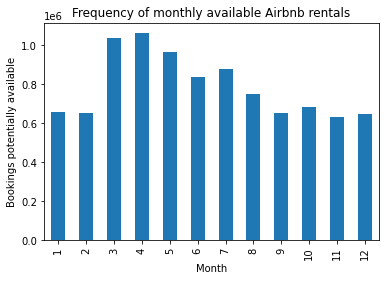

In [83]:
calendar_one_year.loc[calendar_one_year.available == 't'].groupby(calendar_one_year.date.dt.month).size().plot(kind='bar')
plt.xlabel('Month')
plt.ylabel('Bookings potentially available')
plt.title( 'Frequency of monthly available Airbnb rentals')
plt.show()

>If all listings were to be booked for a whole year, this would generate a revenue of around $1.45 billion in London alone.

In [45]:
calendar_one_year.loc[calendar.available == 't'].groupby(calendar.date.dt.month).adjusted_price.sum().sum()

1271092259.0

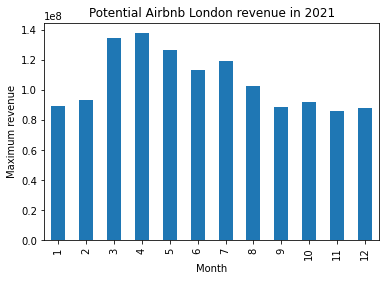

In [46]:
calendar_one_year.loc[calendar.available == 't'].groupby(calendar.date.dt.month).adjusted_price.sum().plot(kind='bar', title='Potential Airbnb London revenue in 2021')
plt.xlabel('Month')
plt.ylabel('Maximum revenue')
plt.show()

>the mean prices of listings doesn't seem to change with day of week

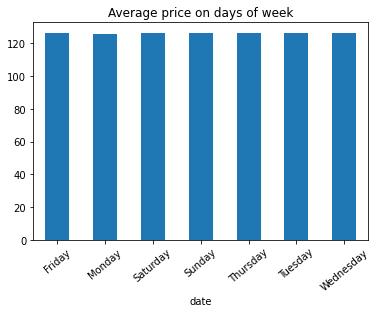

In [85]:
calendar_places.groupby(calendar.date.dt.day_name()).adjusted_price.mean().plot(kind='bar')
plt.xticks(rotation=40)
plt.title('Average price on days of week');

>the listings through the years seem to have covered the entire coordinates of London

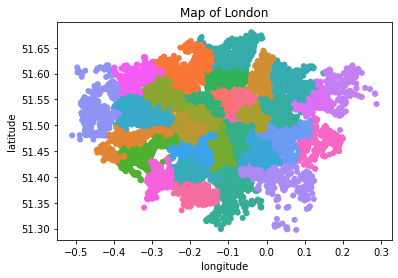

In [48]:
calendar_places_unique_listings = calendar_places[~calendar_places.listing_id.duplicated()]
plot = sns.scatterplot(x='longitude', y='latitude', data=calendar_places_unique_listings, hue='neighbourhood_cleansed', ec=None)
plot.legend_.remove()
plt.title('Map of London');

---

### Analysis on listings availability by season

>Null hypothesis: seasonal availability means are equal
Alternative hypothesis: seasonal availability means are not equal

In [49]:
season_mapping= {1: 'winter', 2: 'winter', 3: 'spring', 4: 'spring', 5: 'spring', 6: 'summer', 7: 'summer', 8: 'summer', 9: 'autumn', 10: 'autumn', 11: 'autumn', 12: 'winter'}
calendar_one_year['season'] = calendar_one_year.date.dt.month.map(season_mapping)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [50]:
calendar_one_year.groupby(['season', 'available']).size().unstack(0)

season,autumn,spring,summer,winter
available,,,,
f,4994654,3970936,4573622,4728858
t,1969485,3069732,2467046,1960407


In [51]:
season_availability = pd.crosstab(calendar_one_year.available, calendar_one_year.season, margins=True)
season_availability

season,autumn,spring,summer,winter,All
available,,,,,
f,4994654,3970936,4573622,4728858,18268070
t,1969485,3069732,2467046,1960407,9466670
All,6964139,7040668,7040668,6689265,27734740


In [52]:
season_availability_expected = season_availability.copy()
for season in ['autumn', 'spring', 'summer', 'winter']:
    for av in ['f', 't']:
        season_availability_expected.loc[av, season] = \
            season_availability.loc[av, 'All'] * season_availability[season]['All'] / 27734740

In [53]:
season_availability_expected

season,autumn,spring,summer,winter,All
available,,,,,
f,4.587077e+06,4.637484e+06,4.637484e+06,4.406025e+06,18268070
t,2.377062e+06,2.403184e+06,2.403184e+06,2.283240e+06,9466670
All,6.964139e+06,7.040668e+06,7.040668e+06,6.689265e+06,27734740


In [54]:
chi_squared = 0
for season in ['autumn', 'spring', 'summer', 'winter']:
    for av in ['f', 't']:
        chi_squared += (season_availability.loc[av, season] -
            season_availability_expected.loc[av, season])**2 / season_availability_expected.loc[av, season]
chi_squared

458653.14053528145

>The chi square test statistic is much greater than the chi square critical value. Hence, the null hypothesis has been rejected with 99% confidence.

In [55]:
stats.chi.ppf(0.995, df=3)**2

12.838156466598647

>the mean prices of listings doesn't seem to change with day of week

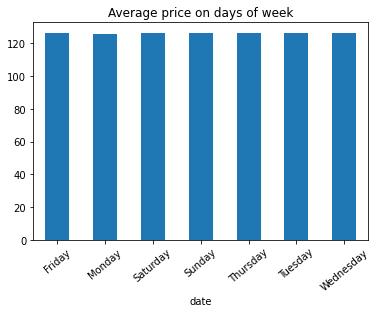

In [86]:
calendar_places.groupby(calendar.date.dt.day_name()).adjusted_price.mean().plot(kind='bar')
plt.xticks(rotation=40)
plt.title('Average price on days of week');

In [57]:
listings_mini = listings[[
    'id', 'host_id','host_name', 'host_since', 'host_response_time', 
    'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 
    'host_verifications','neighbourhood','neighbourhood_cleansed', 
    'latitude', 'longitude', 'property_type', 'room_type', 'accommodates',
    'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
    'has_availability', 'availability_365', 'calendar_last_scraped', 
    'number_of_reviews', 'first_review', 'last_review', 
    'review_scores_rating', 'review_scores_accuracy',
    'review_scores_cleanliness', 'review_scores_checkin', 
    'review_scores_communication', 'review_scores_location',
    'review_scores_value', 'instant_bookable',
    'calculated_host_listings_count_entire_homes',
    'calculated_host_listings_count_private_rooms',
    'calculated_host_listings_count_shared_rooms', 'reviews_per_month'
]]

In [58]:
listings_mini.price = listings_mini.price.str.replace(r'[,|$]', '').astype('float')

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5507: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


>Most hosts have a high overall rating approaching 100

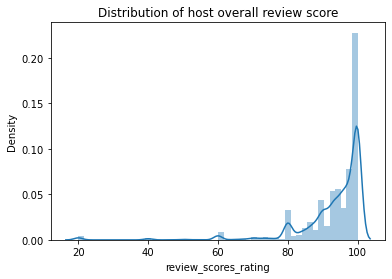

In [59]:
sns.distplot(listings_mini.review_scores_rating)
plt.title('Distribution of host overall review score');

In [60]:
listings_mini.neighbourhood_cleansed.nunique()

33

In [61]:
neighbourhoods_expensive = listings_mini[listings_mini.neighbourhood_cleansed.isin(listings_mini.groupby('neighbourhood_cleansed').price.mean().nlargest(5).index.values) & (listings_mini.price < 500)]
neighbourhoods_cheap = listings_mini[listings_mini.neighbourhood_cleansed.isin(listings_mini.groupby('neighbourhood_cleansed').price.mean().nsmallest(5).index.values) & (listings_mini.price < 500)]

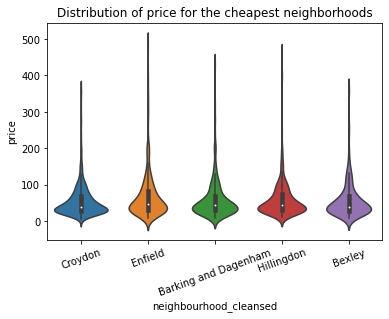

In [88]:
sns.violinplot(x='neighbourhood_cleansed', y='price', data=neighbourhoods_cheap)
plt.xticks(rotation=20)
plt.title('Distribution of price for the cheapest neighborhoods');

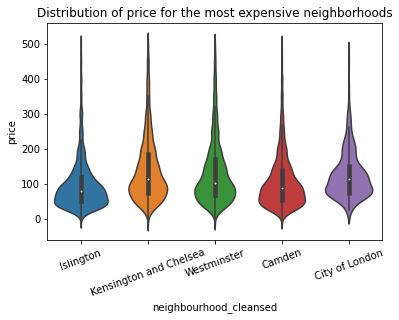

In [89]:
sns.violinplot(x='neighbourhood_cleansed', y='price', data=neighbourhoods_expensive)
plt.xticks(rotation=20)
plt.title('Distribution of price for the most expensive neighborhoods');

In [64]:
listings_mini.bathrooms_text.unique()

array(['1 shared bath', '1 bath', '2 baths', '1 private bath',
       '1.5 shared baths', '1.5 baths', '0 shared baths', nan,
       '2.5 shared baths', '2 shared baths', '2.5 baths',
       'Shared half-bath', '4 baths', '3 baths', '0 baths',
       '3 shared baths', '3.5 baths', 'Half-bath', '5 baths', '4.5 baths',
       '5 shared baths', '3.5 shared baths', 'Private half-bath',
       '7 baths', '4 shared baths', '6 baths', '6 shared baths',
       '5.5 baths', '10 baths', '8.5 baths', '7 shared baths',
       '4.5 shared baths', '6.5 baths', '8 shared baths', '17 baths',
       '11 baths', '7.5 baths', '8 baths', '10.5 baths', '9 baths',
       '12 baths', '9 shared baths', '35 baths', '11.5 baths'],
      dtype=object)

>Convert the bathrooms_text into float representative of number of baths

In [65]:
def find_baths(bathrooms_text):
    if not isinstance(bathrooms_text, str):
        return 0
    elif re.search(r'half', bathrooms_text, flags=re.IGNORECASE):
        return 0.5
    else:
        return float(re.findall("(\d+(?:\.\d+)?)", bathrooms_text)[0])
listings_mini['bathrooms'] = listings_mini.bathrooms_text.map(find_baths)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


>Number of baths doesn't seem to have a clear correlation with price

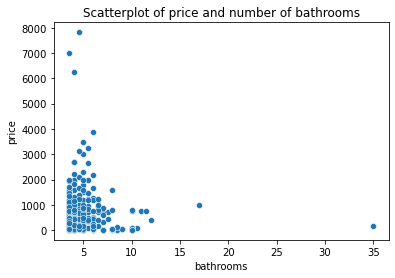

In [66]:
sns.scatterplot(x='bathrooms', y='price', data=listings_mini[listings_mini.bathrooms > 3])
plt.title('Scatterplot of price and number of bathrooms');

In [67]:
listings_mini.bathrooms.corr(listings_mini.price)

0.15059346104712248

In [68]:
listings_mini.bathrooms.describe()

count    76534.000000
mean         1.301859
std          0.619934
min          0.000000
25%          1.000000
50%          1.000000
75%          1.500000
max         35.000000
Name: bathrooms, dtype: float64

>Price has a general upward trend until number of beds reachs 9. Prices fluctuate onwards, which could be due to the lower prices set by boutique hotels.

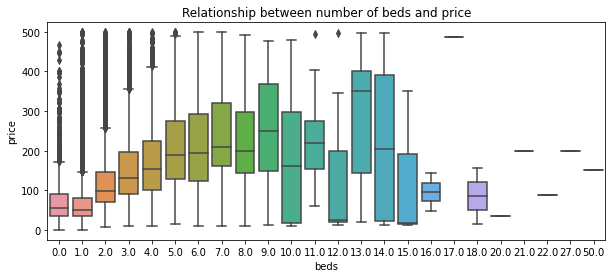

In [69]:
plt.figure(figsize=(10,4))
sns.boxplot(x='beds', y='price', data=listings_mini[listings_mini.price < 500])
plt.title('Relationship between number of beds and price');

>As expected listings for entire home/apartment are usually more expensive

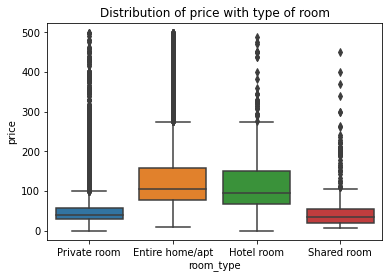

In [70]:
sns.boxplot(x='room_type', y='price', data=listings_mini[listings_mini.price < 500])
plt.title('Distribution of price with type of room');

>The most expensive listings seem to reside in the center of London

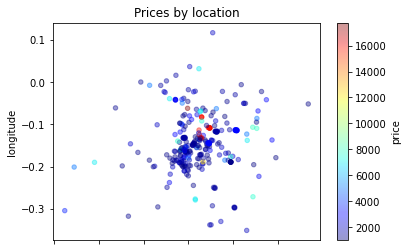

In [71]:
listings_mini[listings_mini.price > 1000].plot(kind='scatter', x='latitude', y='longitude', c='price', cmap=plt.get_cmap('jet'), colorbar=True, alpha=0.4)
plt.title('Prices by location')
plt.show();

In [72]:
listings_mini.groupby('neighbourhood_cleansed').price.mean().nlargest(5)

neighbourhood_cleansed
City of London            258.104308
Westminster               183.478077
Kensington and Chelsea    175.704636
Islington                 144.307487
Camden                    125.717127
Name: price, dtype: float64

In [73]:
listings_mini.groupby('neighbourhood_cleansed').price.mean().nsmallest(5)

neighbourhood_cleansed
Croydon                 56.724320
Bexley                  59.003623
Hillingdon              61.622793
Barking and Dagenham    64.480100
Enfield                 69.067873
Name: price, dtype: float64

>Analysis on the different amenities offered

In [74]:
listings_mini.amenities = listings_mini.amenities.map(lambda x: ast.literal_eval(x))

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5507: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [75]:
listings_mini = listings_mini.join(listings.amenities.str.join('|').str.get_dummies().add_prefix('amenities_'))

In [76]:
listings_mini['price_bracket'] = pd.qcut(listings_mini.price, 4)

In [77]:
amenities_types = [amenity for amenity in listings_mini.columns if amenity.startswith('amenities_')]
listings_amenities = listings_mini[amenities_types + ['price_bracket']]

In [78]:
amenities_count = pd.pivot_table(listings_amenities, index=['price_bracket'], values=amenities_types, aggfunc=np.sum)
amenities_count

,amenities_,"amenities_""",amenities_&,amenities_',amenities_(,amenities_),amenities_+,"amenities_,",amenities_-,amenities_.,amenities_/,amenities_0,amenities_1,amenities_2,amenities_3,amenities_4,amenities_5,amenities_6,amenities_7,amenities_8,amenities_9,amenities_:,amenities_A,amenities_B,amenities_C,amenities_D,amenities_E,amenities_F,amenities_G,amenities_H,amenities_I,amenities_J,amenities_K,amenities_L,amenities_M,amenities_N,amenities_O,amenities_P,amenities_Q,amenities_R,amenities_S,amenities_T,amenities_U,amenities_V,amenities_W,amenities_X,amenities_Y,amenities_Z,amenities_[,amenities_\,amenities_],amenities_a,amenities_b,amenities_c,amenities_d,amenities_e,amenities_f,amenities_g,amenities_h,amenities_i,amenities_j,amenities_k,amenities_l,amenities_m,amenities_n,amenities_o,amenities_p,amenities_q,amenities_r,amenities_s,amenities_t,amenities_u,amenities_v,amenities_w,amenities_x,amenities_y,amenities_z
price_bracket,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
"(-0.001, 42.0]",19245,19246,2,1,1,1,0,19143,448,1,181,535,535,541,93,18,14,4,4,3,451,30,684,8327,12725,14201,17518,12139,3383,18730,12694,4,16721,16791,5778,111,5307,5611,535,6546,17248,8869,2,8842,18912,1,0,5,19258,542,19258,19243,15228,18670,18860,19244,18711,19131,18728,19134,0,18203,19160,19015,19242,19157,16038,0,19222,19223,19242,10144,9994,18118,12885,18210,536
"(42.0, 75.0]",20426,20432,2,0,0,0,0,20296,673,0,508,972,969,974,103,12,16,2,5,4,885,60,1098,9788,14581,16070,19033,11604,2992,19826,14837,2,17922,17767,6412,150,6581,8284,481,8066,18858,13049,2,13044,20053,1,0,2,20446,982,20446,20425,16192,19769,20120,20428,19735,20359,19933,20301,0,19314,20375,20259,20426,20375,17691,0,20412,20412,20422,10456,12675,19385,14213,19650,541
"(75.0, 120.0]",17900,17905,4,1,0,1,6,17824,964,1,893,1567,1567,1570,141,18,34,12,4,3,1468,71,1230,9241,14112,15356,17082,9847,3003,17563,14308,3,16862,15761,6494,227,7419,8995,551,8334,16940,13861,2,13848,17661,1,0,1,17916,1582,17916,17902,14871,17639,17703,17904,17343,17855,17689,17825,1,17220,17873,17804,17903,17865,16068,0,17891,17890,17903,9724,12799,17212,13281,17461,656
"(120.0, 17746.0]",18904,18905,4,27,2,2,6,18817,1356,0,1642,2611,2609,2613,160,21,31,16,3,6,2526,95,2508,10468,15108,16831,17869,10797,4113,18578,16325,0,17886,17138,8316,298,9045,10319,935,9642,17877,16710,0,16707,18674,0,1,3,18914,2617,18914,18903,16019,18663,18787,18904,18416,18880,18728,18814,0,18014,18880,18831,18902,18872,17144,5,18900,18895,18899,11412,14335,18450,13823,18682,674


>The amenities that are discriminative of the differet price brackets include TV, bedroom lock, dishwasher, and so on

In [79]:
amenities_variations = amenities_count[amenities_count.std().nlargest(10).index]
amenities_variations

,amenities_V,amenities_T,amenities_P,amenities_v,amenities_O,amenities_I,amenities_R,amenities_D,amenities_M,amenities_[
price_bracket,,,,,,,,,,
"(-0.001, 42.0]",8842,8869,5611,9994,5307,12694,6546,14201,5778,19258
"(42.0, 75.0]",13044,13049,8284,12675,6581,14837,8066,16070,6412,20446
"(75.0, 120.0]",13848,13861,8995,12799,7419,14308,8334,15356,6494,17916
"(120.0, 17746.0]",16707,16710,10319,14335,9045,16325,9642,16831,8316,18914


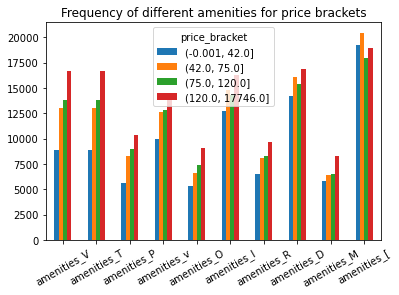

In [93]:
amenities_variations.T.plot(kind='bar')
plt.xticks(rotation=30)
plt.title('Frequency of different amenities for price brackets');

>On the other hand Wifi, heating, and kitchen are more or less offered on all price brackets

In [81]:
for i in range(4):
    print(amenities_count.index[i], '-'*20)
    print(amenities_count.iloc[i].nlargest())

(-0.001, 42.0] --------------------
amenities_[    19258
amenities_]    19258
amenities_"    19246
amenities_     19245
amenities_e    19244
Name: (-0.001, 42.0], dtype: int64
(42.0, 75.0] --------------------
amenities_[    20446
amenities_]    20446
amenities_"    20432
amenities_e    20428
amenities_     20426
Name: (42.0, 75.0], dtype: int64
(75.0, 120.0] --------------------
amenities_[    17916
amenities_]    17916
amenities_"    17905
amenities_e    17904
amenities_n    17903
Name: (75.0, 120.0], dtype: int64
(120.0, 17746.0] --------------------
amenities_[    18914
amenities_]    18914
amenities_"    18905
amenities_     18904
amenities_e    18904
Name: (120.0, 17746.0], dtype: int64
